In [1]:
%load_ext autoreload  
%autoreload 2  

In [2]:
# Import the Data class from the ocpy library to handle observational data.
from ocpy.data import Data

# Read the dataset from the "ny_vir.xlsx" Excel file.
# The file is expected to contain columns for Time (BJD), O-C values, and Errors.
data = Data.from_file("ny_vir.xlsx")

# Calculate weights for the observations based on their errors (1/sigma^2).
data = data.calculate_weights()

(<Axes: ylabel='O−C'>, <Axes: xlabel='Cycle', ylabel='Resid'>)

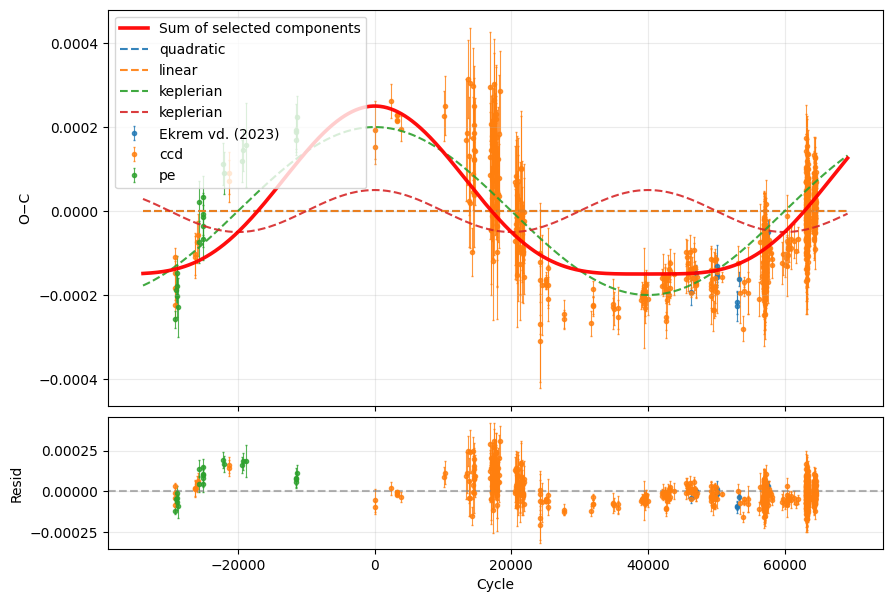

In [3]:
from ocpy.oc import Linear, Quadratic, Keplerian, Parameter

# Calculate O-C values for PyMC modeling.
oc = data.calculate_oc(reference_minimum=2453174.442769,
                       reference_period=0.101015969,
                       model_type="pymc")

# Filter out visual observations.
oc = oc[oc["labels"] != "vis"]

# 1) Linear (y = a*x + b)
lin = Linear(
    a=Parameter(value=0.0,   std=2e-5,  min=-1e-3,  max=1e-3,  fixed=False),
    b=Parameter(value=0.0,   std=2e-3,  min=-0.1,   max=0.1,   fixed=False),
)

# 2) Quadratic (q * x^2)
quad = Quadratic(
    q=Parameter(value=0.0,   std=5e-10, min=-1e-8,  max=1e-8,  fixed=False),
)

# 3) Keplerian component #1 (approx 80k epoch)
lite1 = Keplerian(
    P     = Parameter(value=80000,  std=8_000,  min=30_000,  max=150_000, fixed=False),
    T0    = Parameter(value=60000,  std=5_000,                          fixed=False),
    amp   = Parameter(value=2.0e-4, std=1.0e-4, min=0.0,    max=1.0e-3,  fixed=False),
    e     = Parameter(value=0.0,    fixed=True),
    omega = Parameter(value=0.0,    fixed=True),
)

# 4) Keplerian component #2 (approx 40k epoch)
lite2 = Keplerian(
    P     = Parameter(value=40000,  std=6_000,  min=10_000,  max=100_000, fixed=False),
    T0    = Parameter(value=30000,  std=5_000,                          fixed=False),
    amp   = Parameter(value=5.0e-5, std=2.5e-5, min=0.0,    max=5.0e-4,  fixed=False),
    e     = Parameter(value=0.0,    fixed=True),
    omega = Parameter(value=0.0,    fixed=True),
)

oc.plot(model=[quad, lin, lite1, lite2])


In [4]:
res = oc.fit([lin, quad, lite1, lite2],
             progressbar=True, draws=3000, tune=2000, chains=4,
             target_accept=0.9)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [linear_a, linear_b, quadratic_q, keplerian1_amp, keplerian1_P, keplerian1_T0, keplerian2_amp, keplerian2_P, keplerian2_T0]


Output()

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 512 seconds.


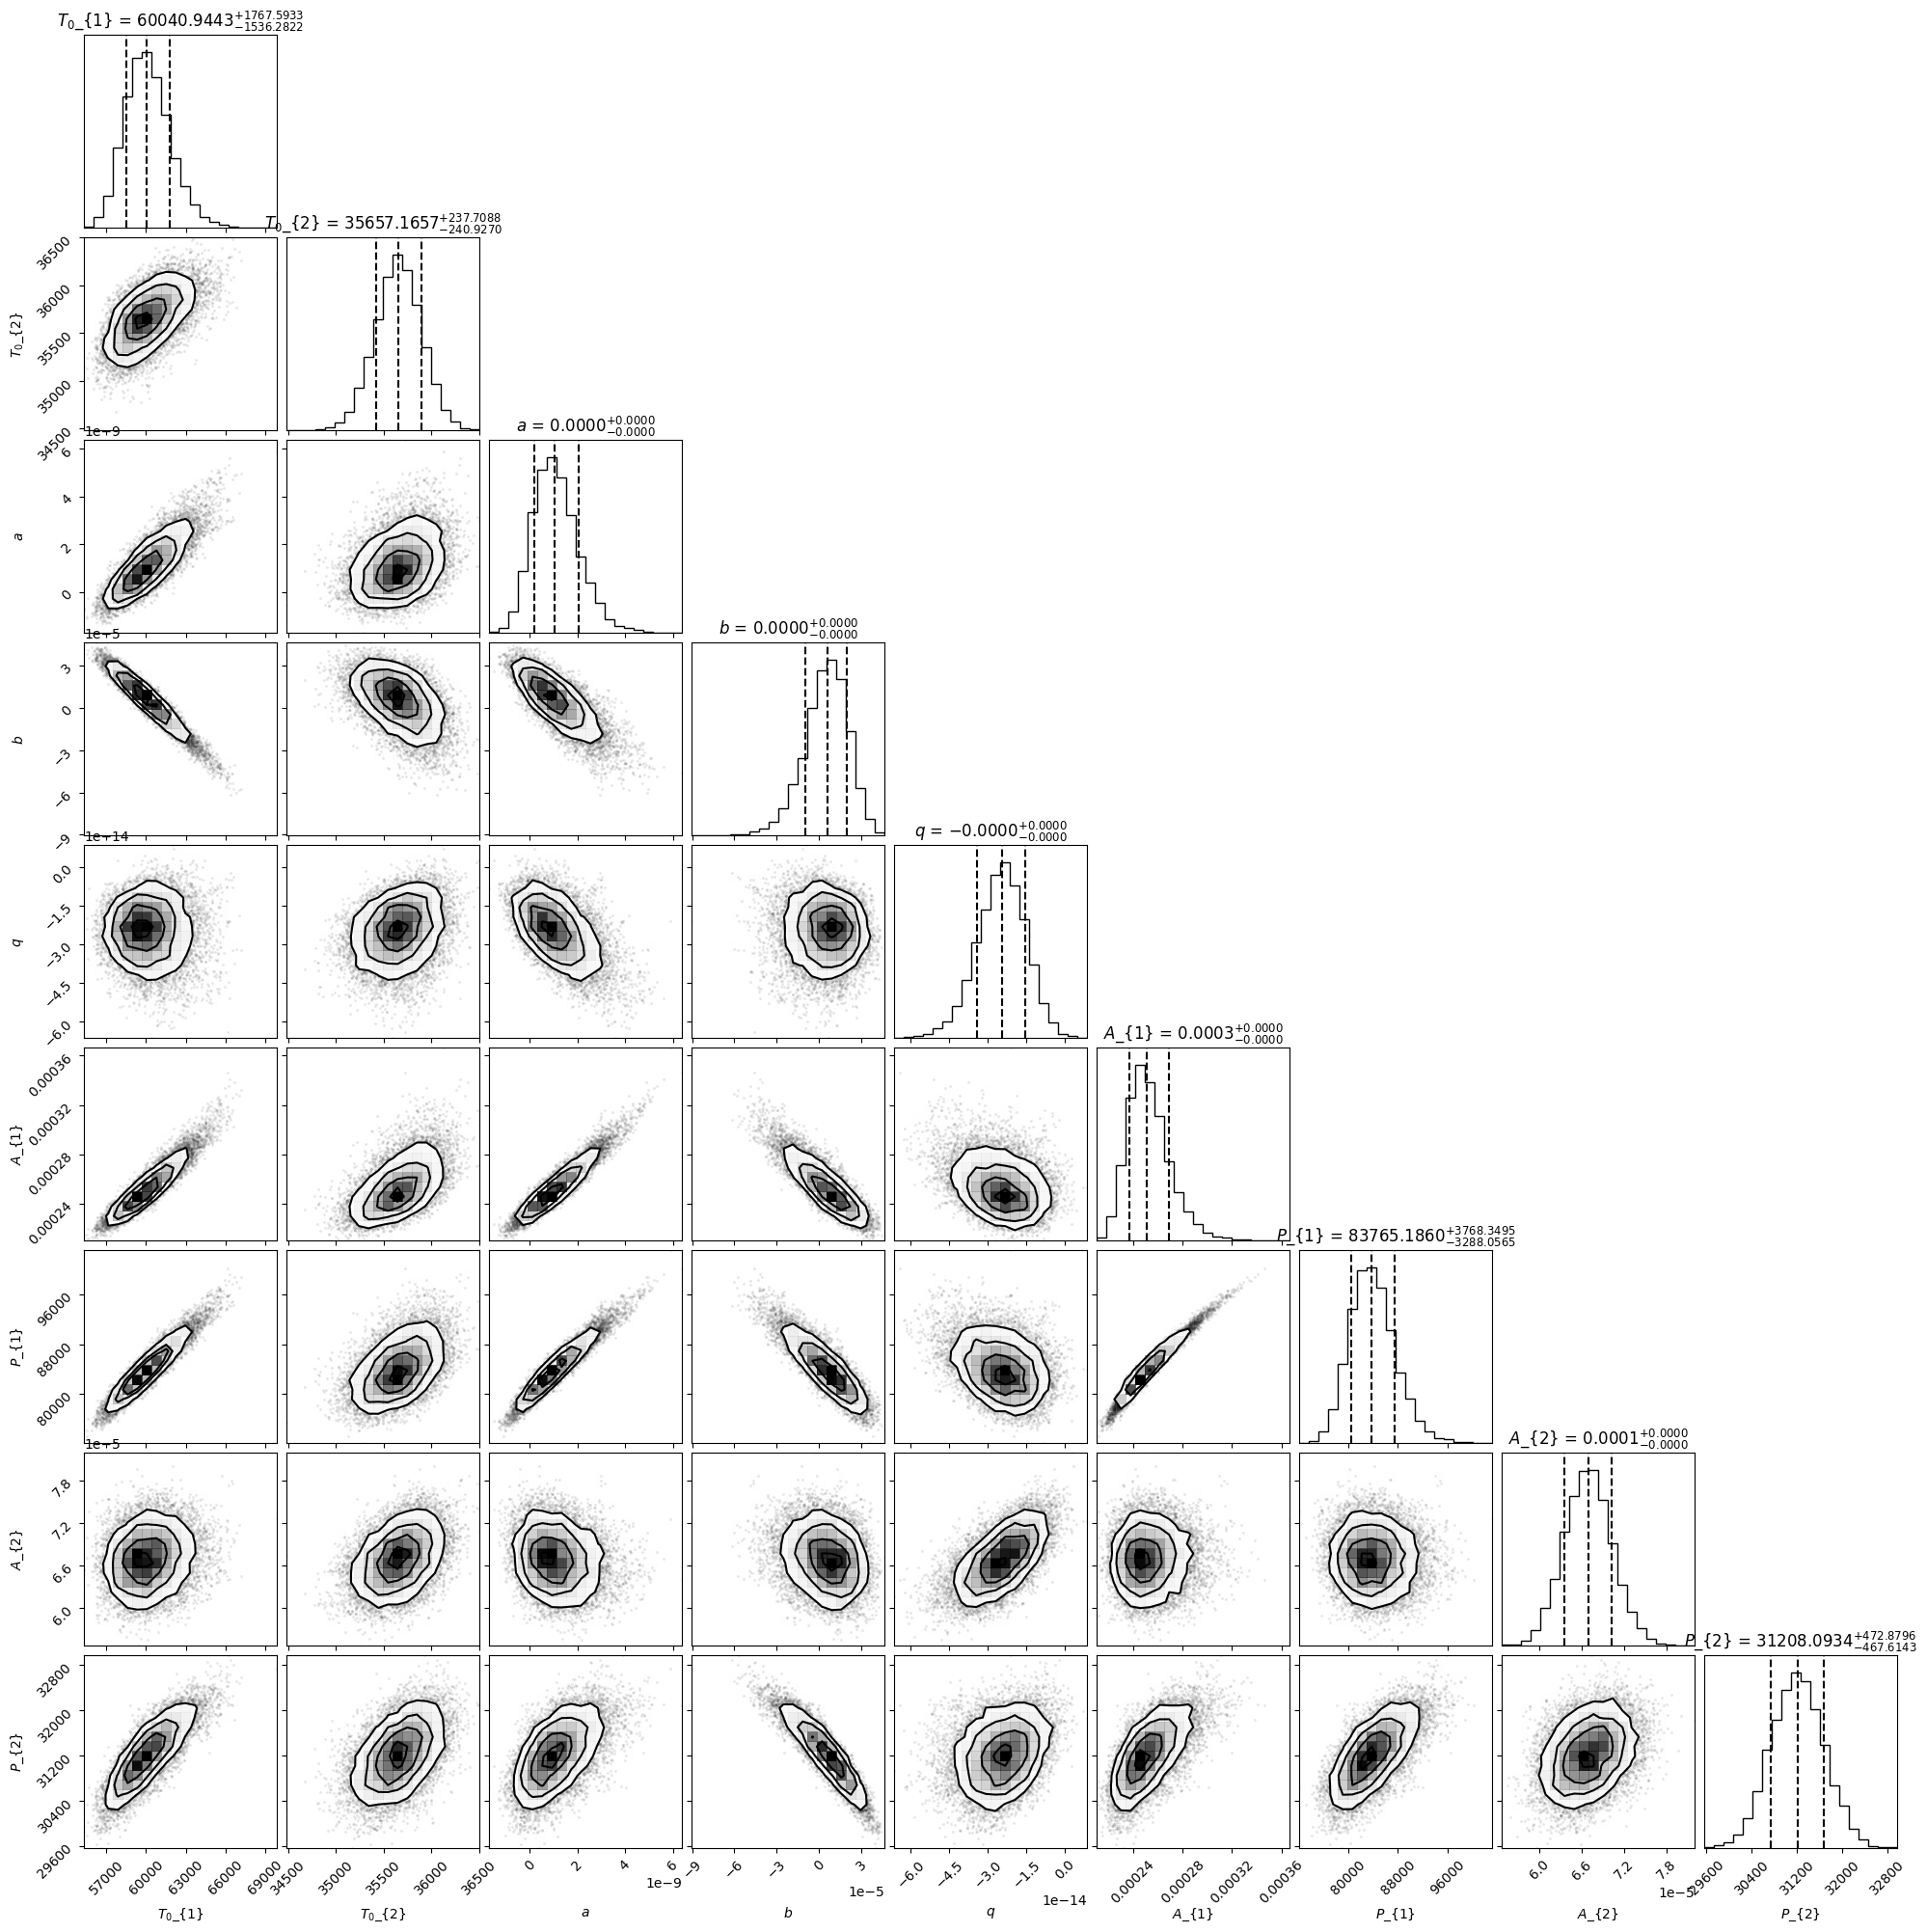

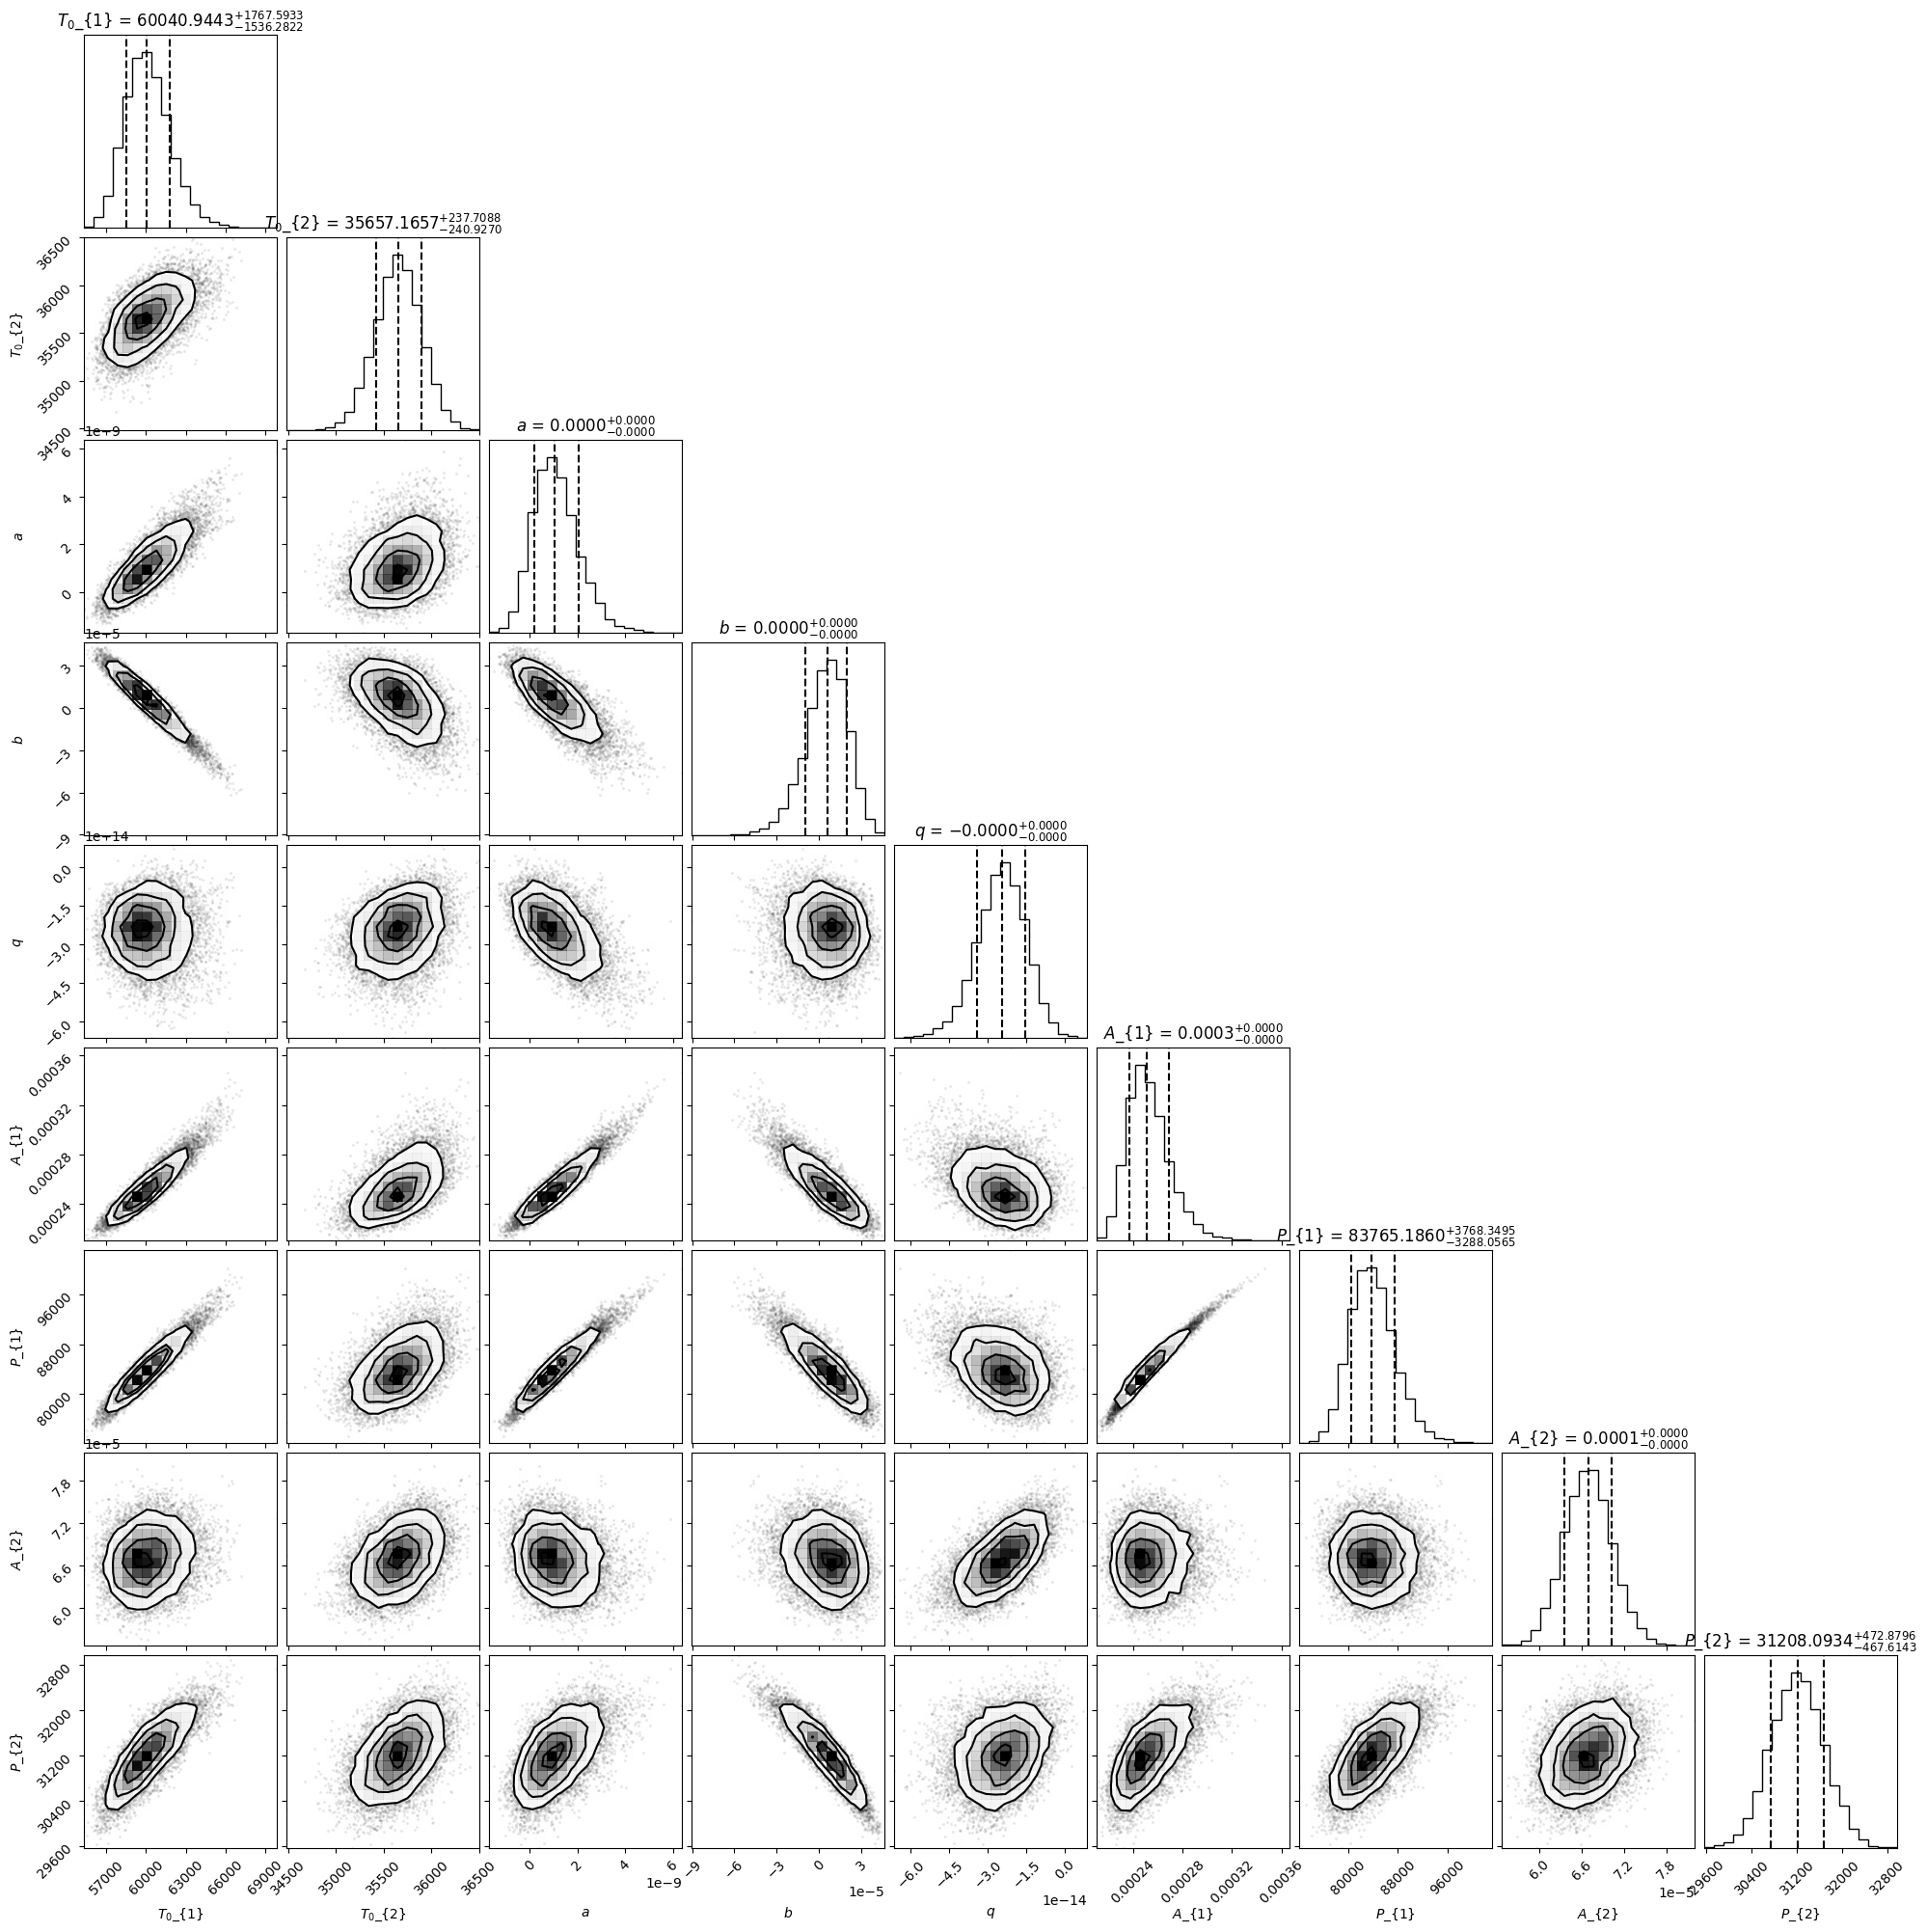

In [5]:
from ocpy.visualization import Plot
Plot.plot_corner(res)

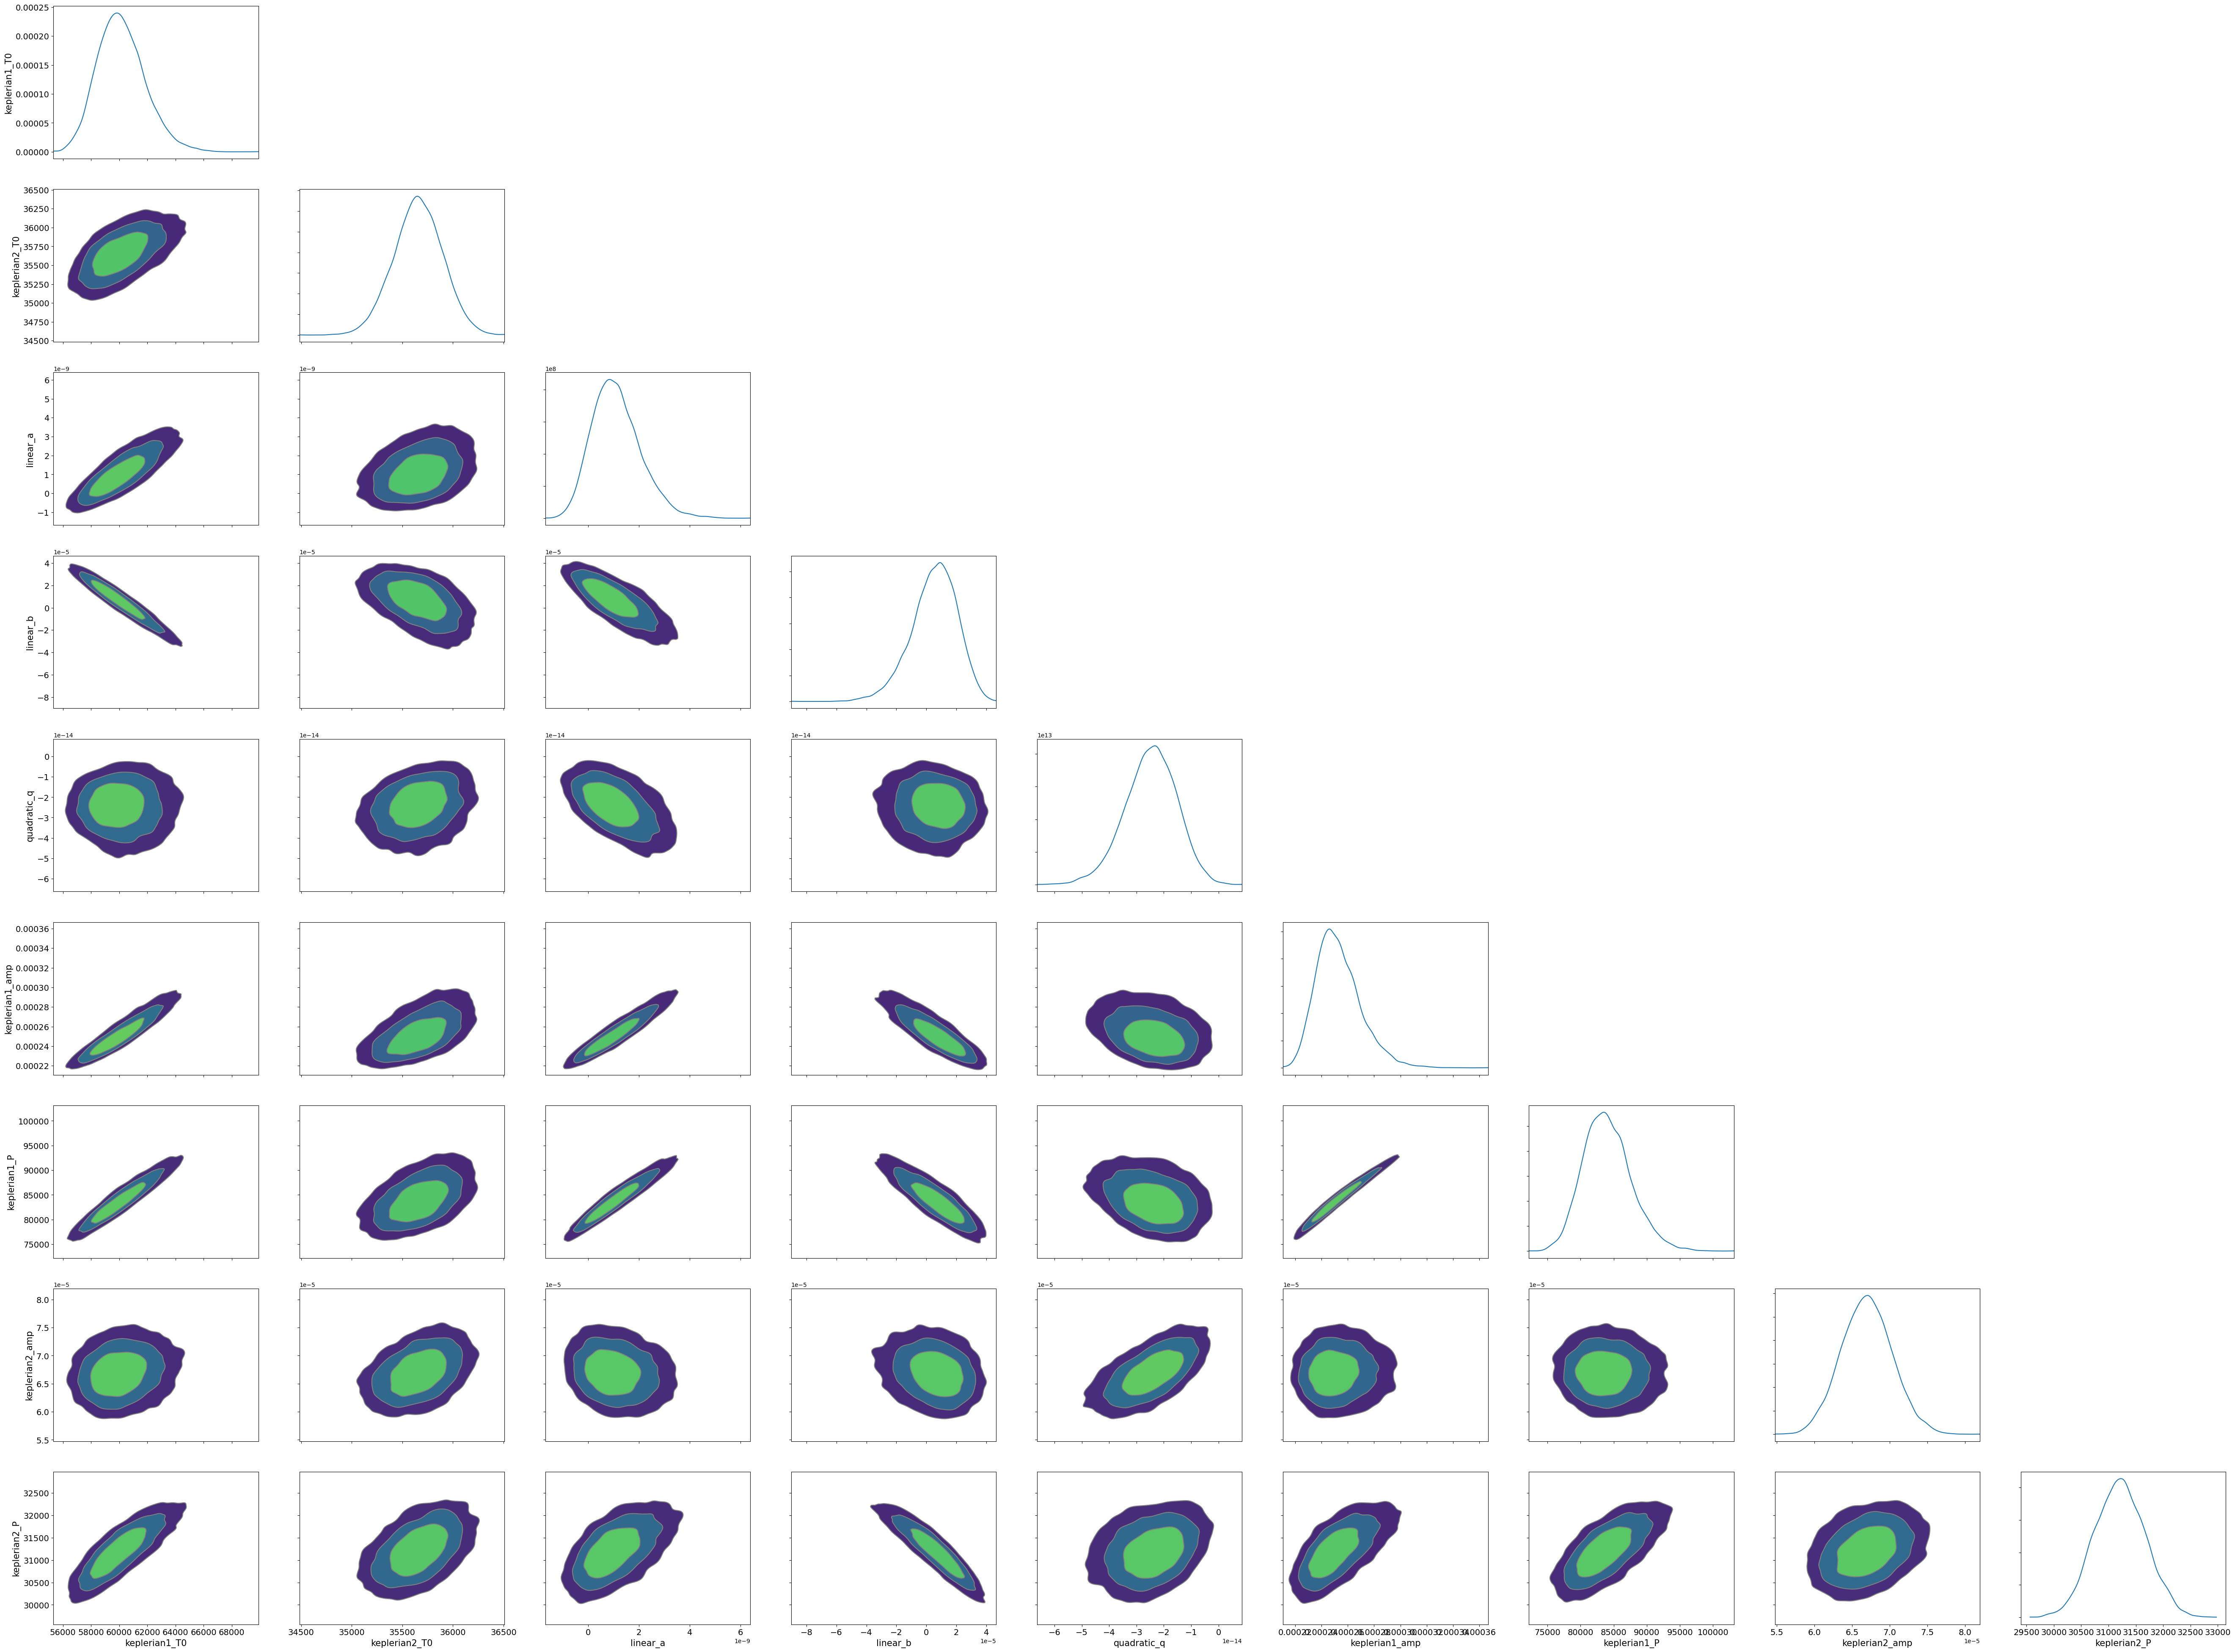

In [6]:
plt = Plot.plot_corner(res, cornerstyle="arviz")


array([[<Axes: title={'center': 'keplerian1_T0'}>,
        <Axes: title={'center': 'keplerian1_T0'}>],
       [<Axes: title={'center': 'keplerian2_T0'}>,
        <Axes: title={'center': 'keplerian2_T0'}>],
       [<Axes: title={'center': 'linear_a'}>,
        <Axes: title={'center': 'linear_a'}>],
       [<Axes: title={'center': 'linear_b'}>,
        <Axes: title={'center': 'linear_b'}>],
       [<Axes: title={'center': 'keplerian1_amp'}>,
        <Axes: title={'center': 'keplerian1_amp'}>],
       [<Axes: title={'center': 'keplerian1_P'}>,
        <Axes: title={'center': 'keplerian1_P'}>],
       [<Axes: title={'center': 'keplerian2_amp'}>,
        <Axes: title={'center': 'keplerian2_amp'}>],
       [<Axes: title={'center': 'keplerian2_P'}>,
        <Axes: title={'center': 'keplerian2_P'}>]], dtype=object)

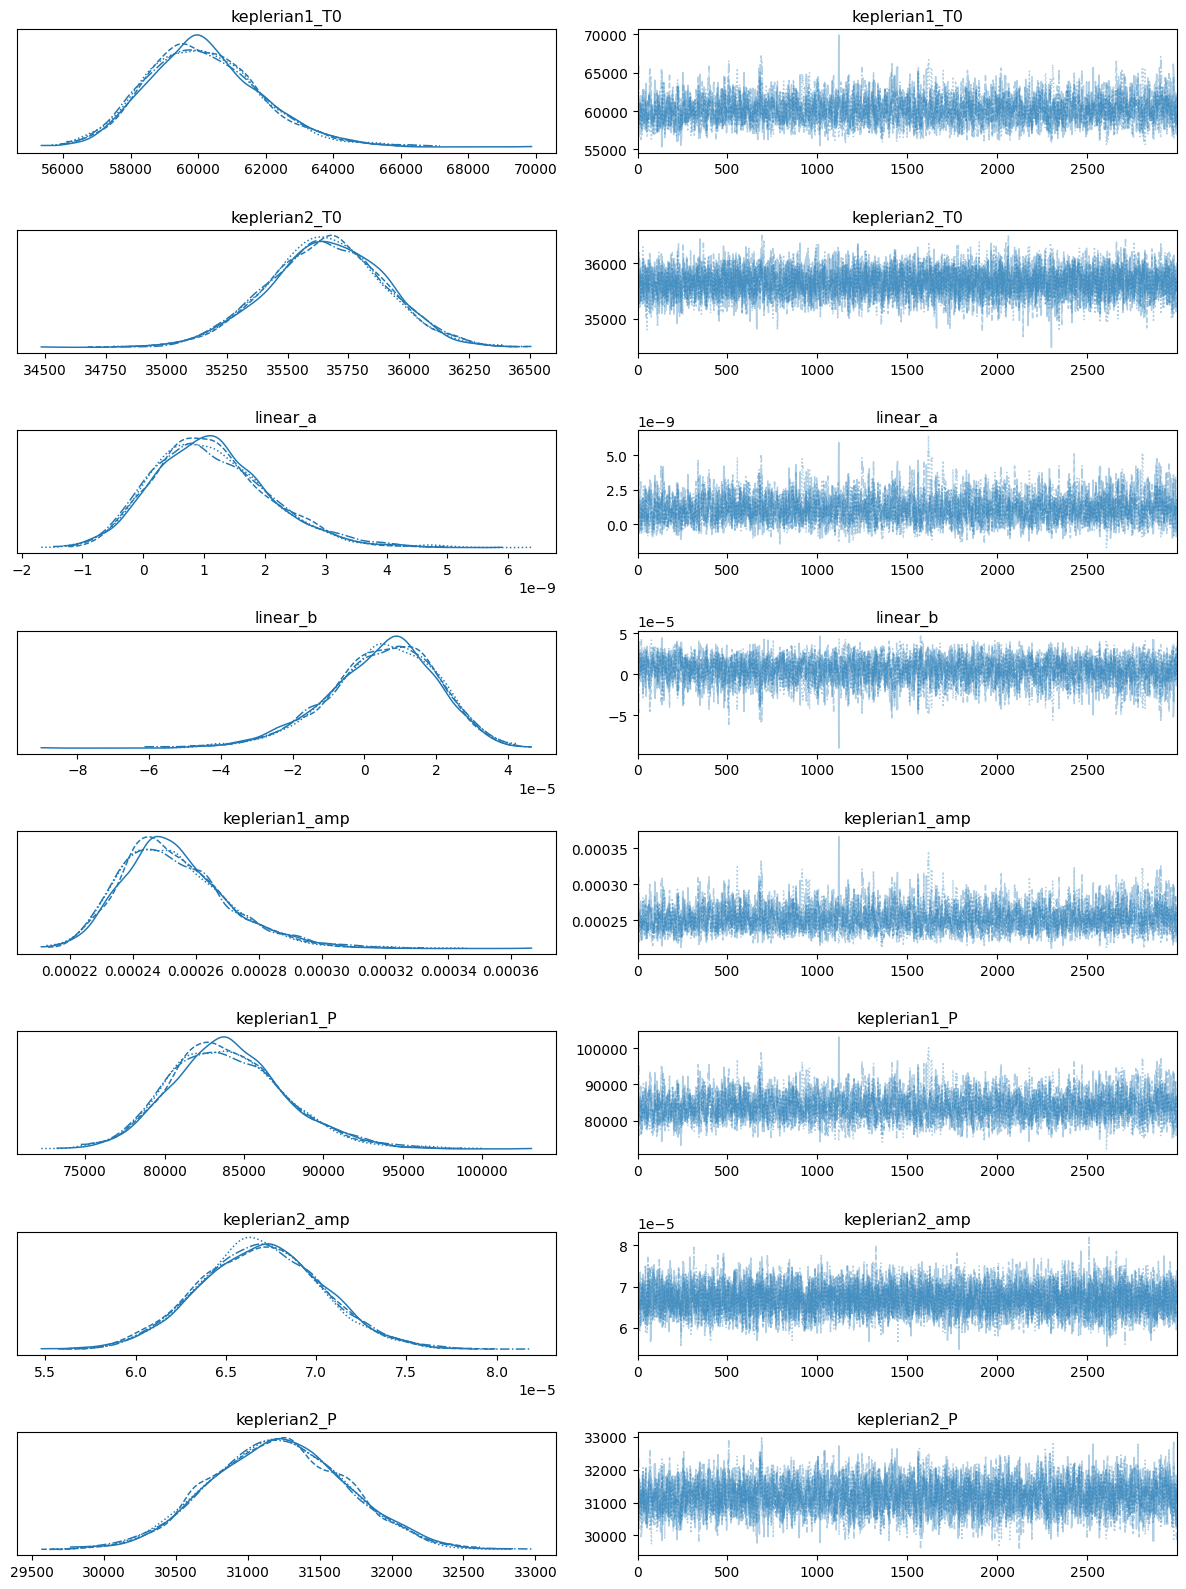

In [14]:
Plot.plot_trace(res)

C:\Users\bar1s\Desktop\oc_py_bar1\oc_py\src\ocpy\visualization.py:462: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


(<Axes: ylabel='O−C'>, <Axes: xlabel='Cycle', ylabel='Resid'>)

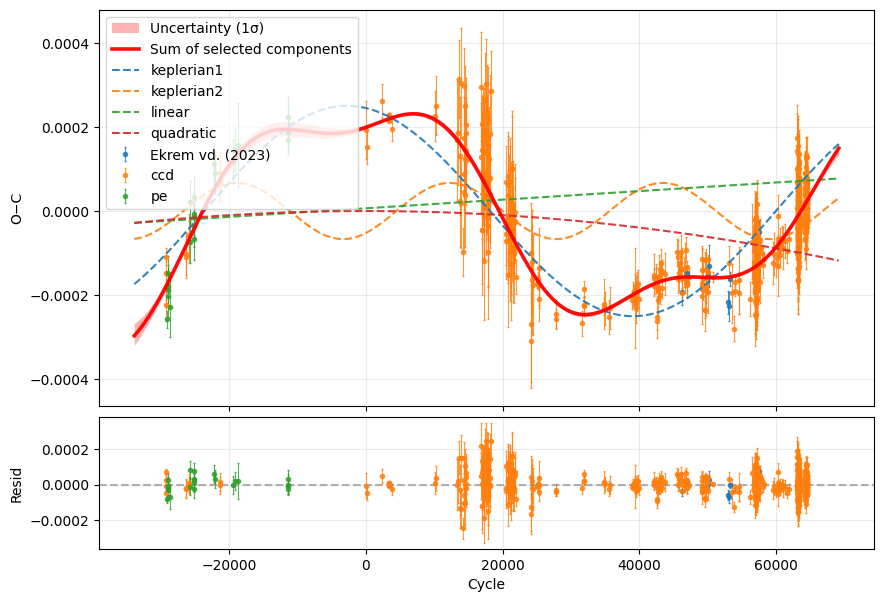

In [ ]:
oc.plot(res)

In [ ]:
res

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data